##### Import Markdown

In [18]:
# Core data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# date time libraries
from datetime import date
from dateutil.relativedelta import relativedelta

# Time series analysis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression

# Handling warnings
import warnings

# Suppress only specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.set_option('mode.chained_assignment', None) # Suppresses the warning

In [19]:
def linear_regression(data, col):
    data = stationary
    time_index = np.arange(len(data)).reshape(-1, 1)
    col = 'data'

    # Add trend line
    # Fit model
    model = LinearRegression()
    model.fit(time_index, data[col].values)

    # Generate predictions
    trend_line = model.predict(time_index)
    return trend_line

In [20]:
def plot_data(data, col, yticks, colors, title, ylabel, trend_line=False):

    # Plot Credit Spread Data
    fig, ax = plt.subplots(figsize=(16,8))


    ax.plot(data.index, data['{}'.format(col)], linewidth=2, color=colors[0], label="{}".format(ylabel))

    if trend_line == True:
        # Add trend line
        lr = linear_regression(data, col)
        ax.plot(data.index, lr, linestyle = "--", color= colors[1], alpha=0.8, linewidth=2)

    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
    ax.set_yticks(yticks, yticks, fontsize=12)
    ax.tick_params(axis='x', size=12)

    # Position legend between title and plot
    plt.title(title, size=16, fontweight='bold', pad=34)  # Add pad for spacing
    plt.legend(bbox_to_anchor=(0.5, 1.08), loc='upper center', ncol=6, fontsize=12)
    plt.subplots_adjust(top=0.80)  # Make more room at the top
    plt.ylim(min(yticks)-(min(yticks)*.05), max(yticks))
    
    # Add Y-axis grid lines
    plt.grid(axis='y')

    plt.show();

In [21]:
# Split our data
def split_data(dataset_input, data_col, test_size):
    # For final model evaluation - simple train/test split
    def train_test_split_ts(data, test_size=12):
        """
        Simple train/test split for time series
        """
        train_size = len(data) - test_size
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        
        return train_data, test_data
    # Split your data
    train_name, test_name = train_test_split_ts(dataset_input[data_col], test_size=test_size)

    print(f"Train period: {train_name.index[0]} to {train_name.index[-1]}")
    print(f"Test period: {test_name.index[0]} to {test_name.index[-1]}")
    print(f"Train size: {len(train_name)} months")
    print(f"Test size: {len(test_name)} months")

    return train_name, test_name

##### Create Month-End Date Index

In [22]:
# create a set of month-end dates

# Define the start and end dates for your range
end_date = date(2025, 6, 30)
start_date = end_date-relativedelta(months=99)

# Generate the range of month-end dates
# The 'M' frequency alias specifies month-end dates
month_end_dates = pd.date_range(start=start_date, end=end_date, freq='ME')

##### Generate Synthetic Stationary Data Set

In [23]:
# Base stationary series
np.random.seed(42)  # For reproducibility
n_periods = 100  # 5 years monthly
base_series = np.random.normal(0, 1, n_periods)  # Mean-reverting around 0

# Add some autocorrelation to make it more realistic
for i in range(1, len(base_series)):
    base_series[i] = 0.3 * base_series[i-1] + 0.7 * base_series[i]

# Scale to realistic financial metric (maybe credit spreads in basis points)
stationary_data = 250 + base_series * 50  # Mean of 250bp, std ~50bp

# Inject extremes at specific periods
extreme_periods = [15, 32, 65]  # Month 15, 32, 45
extreme_values = [450, 100, 380]  # Spike up, crash down, spike up

for period, value in zip(extreme_periods, extreme_values):
    stationary_data[period] = value


stationary = pd.DataFrame()
stationary['data'] = stationary_data
stationary['me_dates'] = month_end_dates
stationary = stationary.set_index('me_dates')

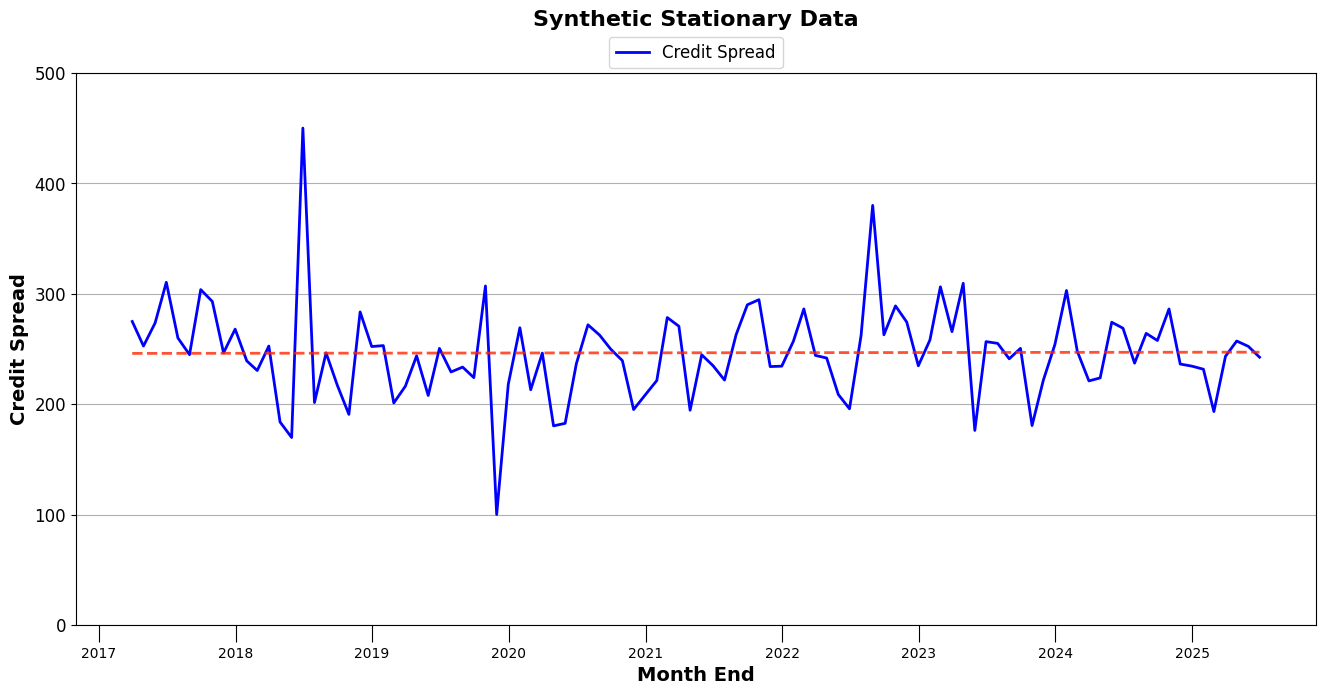

In [24]:
# Plot Ccomponents
title = "Synthetic Stationary Data"
yticks = [0, 100, 200, 300, 400, 500]
colors= ["Blue", "#ff2600", "#ff6700", "#ff8d00", "#ffac00", "#ffc800"]

plot_data(stationary, 'data', yticks, colors, title, 'Credit Spread', trend_line=True)

In [25]:
## Split the data
train_data, test_data = split_data(stationary, 'data', 12)

Train period: 2017-03-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 88 months
Test size: 12 months


In [30]:
def arima_testing(train_data):
    # Start by running an ARIMA model on the recovery data
    # Use your recovery training data
    recovery_train = rec_train_data  # Your 66-month training set
    recovery_test = rec_test_data   # Your 12-month test set

    # Test different p,q combinations (d=0 for stationary data)
    arima_configs = [(0,0,1), (1,0,0), (1,0,1), (2,0,1), (1,0,2), (2,0,2)]
    results = []

    for p, d, q in arima_configs:
        model = ARIMA(recovery_train, order=(p, d, q))
        fitted_model = model.fit()
            
        # Generate forecast
        forecast = fitted_model.forecast(steps=len(recovery_test))
            
        # Calculate performance
        mape = np.mean(np.abs((recovery_test - forecast) / recovery_test)) * 100
        aic = fitted_model.aic
            
        results.append({
                'order': (p, d, q),
                'aic': aic,
                'mape': mape,
                'forecast': forecast,
                'model': fitted_model
            })
            
        print(f"ARIMA{(p,d,q)}: AIC={aic:.1f}, MAPE={mape:.2f}%")
            

    # Find best model
    best_model = min(results, key=lambda x: x['aic'])
    print(f"\nBest ARIMA model: {best_model['order']}")
    print(f"AIC: {best_model['aic']:.1f}, MAPE: {best_model['mape']:.2f}%")
    return best_model['order']


In [32]:
best_model = arima_testing(train_data)

ARIMA(0, 0, 1): AIC=925.8, MAPE=6.81%
ARIMA(1, 0, 0): AIC=925.8, MAPE=6.81%
ARIMA(1, 0, 1): AIC=927.7, MAPE=6.81%
ARIMA(2, 0, 1): AIC=928.8, MAPE=6.67%
ARIMA(1, 0, 2): AIC=928.9, MAPE=6.68%
ARIMA(2, 0, 2): AIC=930.5, MAPE=6.64%

Best ARIMA model: (0, 0, 1)
AIC: 925.8, MAPE: 6.81%


In [35]:
# Fit the best model from the ARIMA process
best_arima = ARIMA(train_data, order=best_model)
best_fitted = best_arima.fit()

# Generate forecasts
arima_forecast = best_fitted.forecast(steps=len(test_data))
arima_fitted_values = best_fitted.fittedvalues

# Get prediction intervals
forecast_result = best_fitted.get_forecast(steps=len(test_data))
arima_ci = forecast_result.conf_int()

#print(f"ARIMA forecast range: ${arima_forecast.min():,.0f} to ${arima_forecast.max():,.0f}")
#print(f"Actual test range: ${test_data.min():,.0f} to ${test_data.max():,.0f}")

<Axes: xlabel='me_dates'>

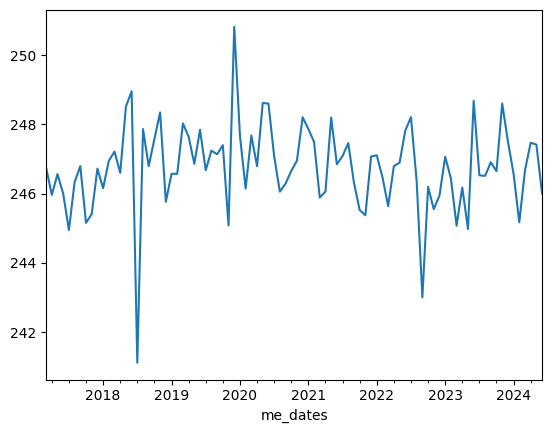

In [ ]:
# Add arima_train and arima_forecast and arima (with all fitted values) to df